### Dependencies 

In [36]:
import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import export_graphviz

from sklearn.decomposition import PCA


In [2]:
def plot_boundary(X, y, fitted_model):

    plt.figure(figsize=(9.8,5), dpi=100)
    
    for i, plot_type in enumerate(['Decision Boundary', 'Decision Probabilities']):
        plt.subplot(1,2,i+1)

        mesh_step_size = 0.01  # step size in the mesh
        x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
        y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
        if i == 0:
            Z = fitted_model.predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            try:
                Z = fitted_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
            except:
                plt.text(0.4, 0.5, 'Probabilities Unavailable', horizontalalignment='center',
                     verticalalignment='center', transform = plt.gca().transAxes, fontsize=12)
                plt.axis('off')
                break
        Z = Z.reshape(xx.shape)
        plt.scatter(X[y.values==0,0], X[y.values==0,1], alpha=0.4, label='Edible', s=5)
        plt.scatter(X[y.values==1,0], X[y.values==1,1], alpha=0.4, label='Posionous', s=5)
        plt.imshow(Z, interpolation='nearest', cmap='RdYlBu_r', alpha=0.15, 
                   extent=(x_min, x_max, y_min, y_max), origin='lower')
        plt.title(plot_type + '\n' + 
                  str(fitted_model).split('(')[0]+ ' Test Accuracy: ' + str(np.round(fitted_model.score(X, y), 5)))
        plt.gca().set_aspect('equal');
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.08, wspace=0.02)

## Multiclass 

## knn-neighors

### 1. Fruits
Examining data

In [3]:
fruits = pd.read_table('fruit_data_with_colors.txt')

In [4]:
fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [5]:
# mapping label : name
fruit_names=dict(zip(fruits.fruit_label.unique(), fruits.fruit_name.unique()))
fruit_names

{1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

In [6]:
from matplotlib import cm

In [7]:
features=['height', 'width', 'mass', 'color_score']

X = fruits[features]
y = fruits['fruit_label']

X_train, X_test, y_train, y_test = train_test_split(X, y)


C:\Users\moi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


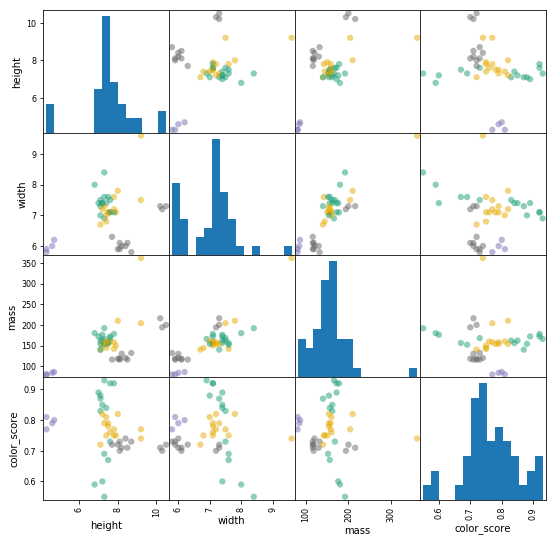

In [8]:
cmap = cm.get_cmap('Dark2')
scatter = pd.scatter_matrix(X_train, c= y_train, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap=cmap)

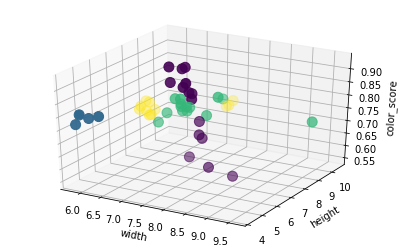

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_train['width'], X_train['height'], X_train['color_score'], c = y_train, marker = 'o', s=100)
ax.set_xlabel('width')
ax.set_ylabel('height')
ax.set_zlabel('color_score')
plt.subplots_adjust(left=0.125, bottom=0.1, right=1.0, top=0.9)
plt.show()

In [10]:
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [11]:
knn=KNeighborsClassifier(n_neighbors=5)

In [12]:
knn.fit(X_train_scaled, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

### Metrics 

In [13]:
print('Accuracy of training set: {:.2f} %\n\nAccuracy of test set: {:.2f} %'
      .format(knn.score(X_train_scaled, y_train)*100, knn.score(X_test_scaled, y_test)*100))

Accuracy of training set: 93.18 %

Accuracy of test set: 100.00 %


### Prediction 

In [14]:
pred=knn.predict([[5.5, 2.1, 10, 0.67]])
fruit_names[pred[0]]

'lemon'

### Accuracy vs. number of neighbors 

([<matplotlib.axis.YTick at 0x2cce9b54860>,
 <a list of 3 Text yticklabel objects>)

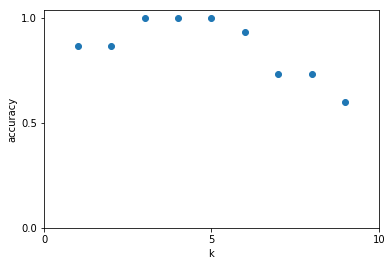

In [15]:
k_range = range(1,10)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10]);
plt.yticks([0,0.5,1])

### Accuracy vs. train/test split proportion

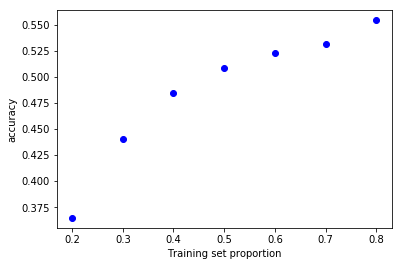

In [16]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 5)

plt.figure()

for s in t:

    scores = []
    for i in range(1,1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-s)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
    plt.plot(s, np.mean(scores), 'bo')

plt.xlabel('Training set proportion')
plt.ylabel('accuracy');


## 2. Mushrooms 

 Data: based on the UCI Mushroom Data Set. <br>
 They are stored in mushrooms.csv.<br>
 Goal: recognize, which mushrooms are edible, based on 117 properties

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [18]:
df = pd.read_csv('mushrooms.csv')
df2 = pd.get_dummies(df)

In [19]:
df3=df2.sample(frac=0.08)
df3.head()

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
6896,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2285,0,1,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
8097,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1120,1,0,0,0,0,0,0,1,1,0,...,1,0,0,0,1,0,0,0,0,0
5494,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [20]:
df3.columns

Index(['class_e', 'class_p', 'cap-shape_b', 'cap-shape_c', 'cap-shape_f',
       'cap-shape_k', 'cap-shape_s', 'cap-shape_x', 'cap-surface_f',
       'cap-surface_g',
       ...
       'population_s', 'population_v', 'population_y', 'habitat_d',
       'habitat_g', 'habitat_l', 'habitat_m', 'habitat_p', 'habitat_u',
       'habitat_w'],
      dtype='object', length=119)

In [21]:
X=df3.iloc[:,2:]
y=df3.iloc[:,1]
X.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
6896,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2285,0,0,0,0,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
8097,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
1120,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
5494,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0


In [22]:
pca=PCA(n_components=2).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(pca, y)

#### Plot the dataset 

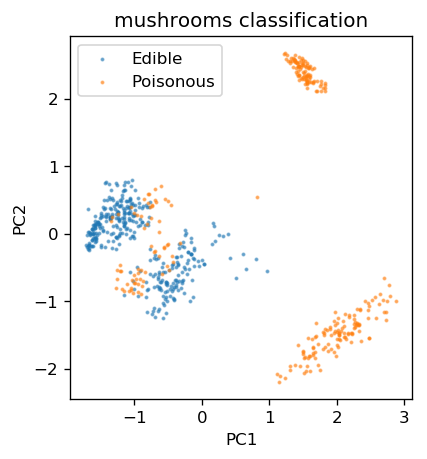

In [23]:
plt.figure(dpi=120)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='Edible', s=2)
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='Poisonous', s=2)
plt.legend()
plt.title('mushrooms classification')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')

### Logistic Regression 

In [24]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
X_train[:5, 1]

array([-0.54618717,  0.41796033,  0.10396671,  0.01744872,  2.34006091])

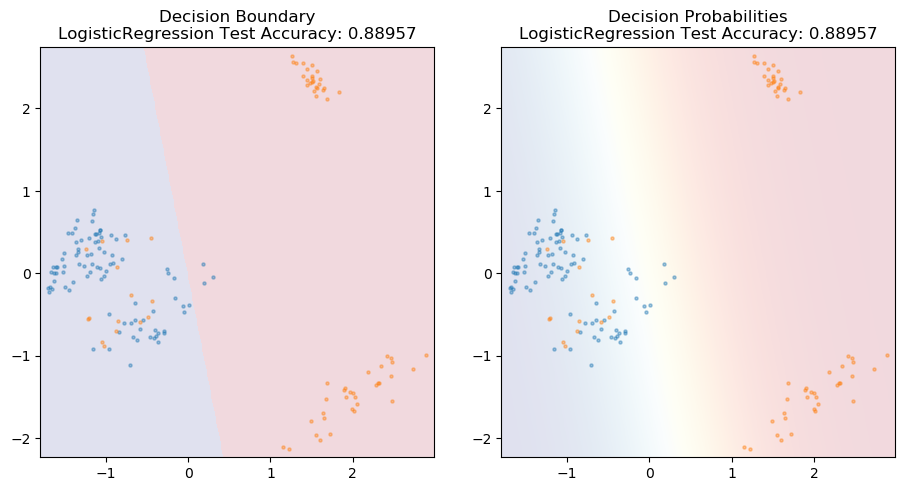

In [26]:
plot_boundary(X_test, y_test, model)

### Regularization (parameter C) 

In [27]:
def plot_class_regions(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles) 

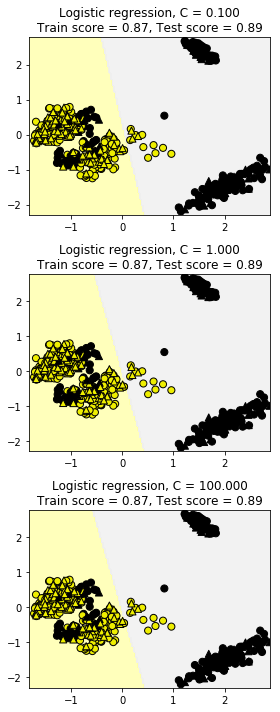

In [28]:
fig, subaxes = plt.subplots(3, 1, figsize=(4, 10))

for i,j in zip([0.1, 1, 100], subaxes):
    #j - subplot
    # i - C parameter
    model = LogisticRegression(C=i).fit(X_train, y_train)
    title ='Logistic regression, C = {:.3f}'.format(i)
    
    plot_class_regions(model, X_train, y_train,
                                             X_test, y_test, title,
                                             j)
plt.tight_layout()

### Support Vector Machines

In [29]:
from sklearn.svm import SVC
parC=1
clf = SVC(kernel = 'rbf', C=parC).fit(X_train, y_train)

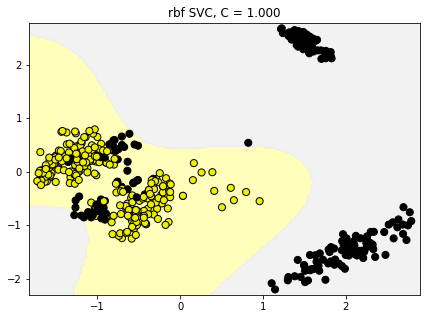

In [30]:
fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
title = 'rbf SVC, C = {:.3f}'.format(parC)
plot_class_regions(clf, X_train, y_train, None, None, title, subaxes)

### Support Vector Machines: different C and gamma

In [31]:
X_train

array([[-0.90527607, -0.54618717],
       [-1.0229453 ,  0.41796033],
       [-1.47420139,  0.10396671],
       [-0.63542514,  0.01744872],
       [ 1.55271922,  2.34006091],
       [-0.79007197,  0.58919162],
       [-1.68584275,  0.36524302],
       [-1.57503379,  0.00697827],
       [-1.22756578,  0.41244713],
       [ 1.37563001,  2.56428313],
       [-0.47063546, -0.9293386 ],
       [ 1.55518306,  2.34571445],
       [-1.61682054, -0.01028359],
       [-1.31445066,  0.00463375],
       [-0.5645161 , -0.2162938 ],
       [-0.2861675 , -0.1323054 ],
       [ 1.42496679,  2.33355335],
       [-1.56784087, -0.07619655],
       [-0.74394465,  0.42030808],
       [-1.50035888, -0.19265316],
       [-1.25519574,  0.43615632],
       [ 1.43261029,  2.62131837],
       [ 1.81958401,  2.15221628],
       [-0.61197011, -0.71318156],
       [-1.59958398,  0.1272354 ],
       [ 1.96679942, -1.16688309],
       [-0.7055855 , -0.28051851],
       [ 1.6468091 , -1.68084273],
       [-0.26137401,

Accuracy of RBF-kernel SVC on training set, gamma=0.01, C= 0.1: 0.87
Accuracy of RBF-kernel SVC on training set, gamma=0.01, C= 1: 0.87
Accuracy of RBF-kernel SVC on training set, gamma=0.01, C= 15: 0.87
Accuracy of RBF-kernel SVC on training set, gamma=0.01, C= 250: 0.87
Accuracy of RBF-kernel SVC on training set, gamma=1, C= 0.1: 0.87
Accuracy of RBF-kernel SVC on training set, gamma=1, C= 1: 0.87
Accuracy of RBF-kernel SVC on training set, gamma=1, C= 15: 0.87
Accuracy of RBF-kernel SVC on training set, gamma=1, C= 250: 0.87
Accuracy of RBF-kernel SVC on training set, gamma=5, C= 0.1: 0.87
Accuracy of RBF-kernel SVC on training set, gamma=5, C= 1: 0.87
Accuracy of RBF-kernel SVC on training set, gamma=5, C= 15: 0.87
Accuracy of RBF-kernel SVC on training set, gamma=5, C= 250: 0.87
Accuracy of RBF-kernel SVC on test set, gamma=5, C= 250: 0.89


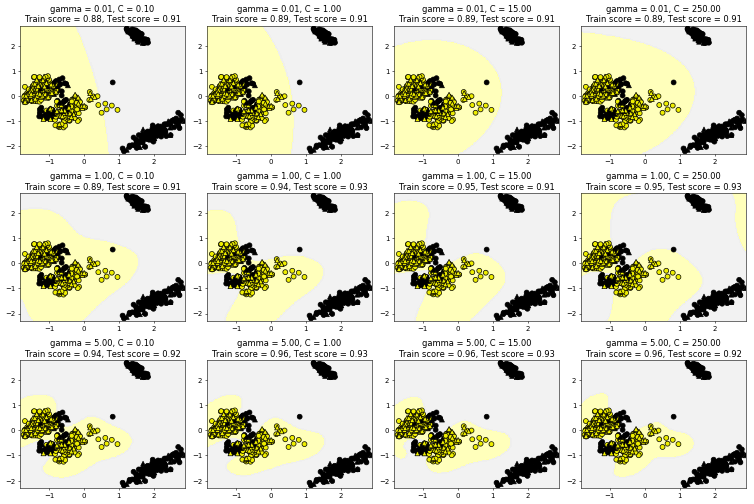

In [37]:
fig, subaxes = plt.subplots(3, 4, figsize=(15, 10), dpi=50)

par_gamma=[0.01, 1, 5]
par_C=[0.1, 1, 15, 250]

for gamma, axis in zip(par_gamma, subaxes):
    
    for C, subplot in zip(par_C, axis):
        title = 'gamma = {:.2f}, C = {:.2f}'.format(gamma, C)
        clf = SVC(kernel = 'rbf', gamma = gamma,
                 C = C).fit(X_train, y_train)
        plot_class_regions(clf, X_train, y_train,
                                                 X_test, y_test, title,
                                                 subplot)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        print('Accuracy of RBF-kernel SVC on training set, gamma={}, C= {}: {:.2f}'
     .format(gamma, C, model.score(X_train, y_train)))
print('Accuracy of RBF-kernel SVC on test set, gamma={}, C= {}: {:.2f}'
     .format(gamma, C, model.score(X_test, y_test)))